In [9]:
#KS200, 기본 코드, overfitting, Train_test_split, cv = TimeSeriesSplit

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
import joblib

# 데이터 불러오기 및 전처리
model_data = pd.read_csv('../main/ks200.csv', encoding='utf-8')

# Label Encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
model_data['레이블'] = encoder.fit_transform(model_data['레이블'])

# 날짜 처리 및 정렬
model_data['날짜'] = pd.to_datetime(model_data['날짜'])
model_data.set_index('날짜', inplace=True)
model_data.sort_index(inplace=True)

# 특성과 레이블 분리
X = model_data.drop(columns=['레이블'])
y = model_data['레이블']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 초기화 및 하이퍼파라미터 그리드 정의
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
param_dist_rf = {
    'n_estimators': [50, 100, 500],
    'max_leaf_nodes': [20, 30, 40, 50],
    'max_features': [1, 2, 3],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 하이퍼파라미터 튜닝
time_split_cv = TimeSeriesSplit(n_splits=10)
rnd_search = RandomizedSearchCV(rnd_clf, param_dist_rf, cv=time_split_cv, random_state =42)
rnd_search.fit(X_train, y_train)

# 최적 모델 선택 및 훈련
best_clf = rnd_search.best_estimator_
best_clf.fit(X_train, y_train)

# 모델 평가
train_score = best_clf.score(X_train, y_train)
test_score = best_clf.score(X_test, y_test)

# 10-fold cross-validation의 정확도 계산
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=time_split_cv, scoring='accuracy')
cv_mean_score = cv_scores.mean()

# label encoding된 값 찾기
up = encoder.transform(['up'])[0]
neutral = encoder.transform(['neutral'])[0]
down = encoder.transform(['down'])[0]

# 혼동 행렬 확인
y_test_pred = best_clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred, labels=[up, neutral, down])
y_all_pred = best_clf.predict(X)
cm_all = confusion_matrix(y, y_all_pred, labels=[up, neutral, down])


# 특성 중요도 확인
feature_importance = list(zip(X_train.columns, best_clf.feature_importances_))

# 모델 저장
joblib.dump(best_clf, "separation22.pkl")

# 10. backtesting용 과거의 예측데이터 생성
y_prediction = best_clf.predict(X) 
y_pred = pd.Series(y_prediction, index=y.index) 

# 결과 출력

# 결과를 출력합니다.
print(f"{rnd_search.best_params_}\n")
print("<10-fold cross-validation>")
print("accuracy score mean: ", cv_mean_score)
print("\n<AI model: machine learning done >")
print("accuracy_score of train data(0.8 of sample): ", train_score)
print("accuracy_score of test data(0.2 of sample): ", test_score)
print("\n<Confusion matrix>")
print("(of test)")
print("up", "neutral", "down")
print(cm_test)
print("(of all)")
print("up", "neutral", "down")
print(cm_all)
# <Feature importance>를 내림차순으로 정렬하여 출력
print("\n<Feature importance>")
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for name, score in sorted_feature_importance:
    print(name, ": ", score)

print("\n< AI model: save >")

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': 50, 'max_features': 3, 'max_depth': 15}

<10-fold cross-validation>
accuracy score mean:  0.8146226415094342

<AI model: machine learning done >
accuracy_score of train data(0.8 of sample):  0.8721129170230967
accuracy_score of test data(0.2 of sample):  0.8427350427350427

<Confusion matrix>
(of test)
up neutral down
[[151  16   2]
 [ 19  99  26]
 [  5  24 243]]
(of all)
up neutral down
[[ 760   77   10]
 [  94  497  128]
 [  15   67 1275]]

<Feature importance>
PBR :  0.10580755694353722
PER :  0.10540610954454843
WTI :  0.0928245797277971
VIX :  0.07501860179976219
통화량 :  0.07357399298804475
수입금액지수 :  0.06966526035063397
경제심리지수 :  0.06795335132640001
환율 :  0.0604525300436016
수출금액지수 :  0.05935444156083608
소비자물가지수 :  0.056108142030278835
경기종합지수 :  0.04996020620724781
미국경제성장률 :  0.04106926557876167
고용률 :  0.040181843323872445
실업률 :  0.03722253840031011
기준금리 :  0.03307059133952391
한국경제성장률 :  0.0323309


< AI 모델: 로드 완료 >

< 데이터 인덱스 확인 >
처음 5개의 인덱스: [Timestamp('2011-04-01 00:00:00'), Timestamp('2011-04-04 00:00:00'), Timestamp('2011-04-05 00:00:00'), Timestamp('2011-04-06 00:00:00'), Timestamp('2011-04-07 00:00:00')]
마지막 5개의 인덱스: [Timestamp('2023-06-26 00:00:00'), Timestamp('2023-06-27 00:00:00'), Timestamp('2023-06-28 00:00:00'), Timestamp('2023-06-29 00:00:00'), Timestamp('2023-06-30 00:00:00')]

< AI 모델: 학습 완료 >
전체 데이터의 정확도:  0.8720492644543277

<현재 상태>
WTI                  :   70.640
환율                   : 1323.070
VIX                  :   13.590
PER                  :   13.790
PBR                  :    0.920
통화량                  : 3795008.400
기준금리                 :    3.500
소비자물가지수              :  111.120
수입금액지수               :  147.330
수출금액지수               :  126.860
경제심리지수               :   92.900
경기종합지수               :   98.900
실업률                  :    2.600
고용률                  :   62.700
한국경제성장률              :    0.600
미국경제성장률              :    0.500

< AI 모델: 예측 >
예측:  ['do

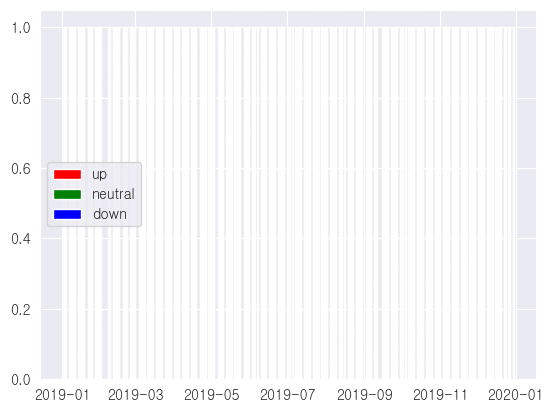

In [10]:
#6-30 예측 시도

import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import joblib 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 모델 및 데이터 파일 경로 설정
MODEL_PATH = "separation22.pkl"  # 경로 수정
DATA_PATH = "../main/ks200.csv"  # 경로 수정

# 1. 모델 로드
rnd_clf = joblib.load(MODEL_PATH) 
print("\n< AI 모델: 로드 완료 >")

# 2. 데이터 로드 및 전처리
model_data = pd.read_csv(DATA_PATH, index_col='날짜', parse_dates=True)
X = model_data.iloc[:, 1:] 
y = model_data["레이블"] 

# 인덱스 확인
print("\n< 데이터 인덱스 확인 >")
print("처음 5개의 인덱스:", model_data.index[:5].tolist())
print("마지막 5개의 인덱스:", model_data.index[-5:].tolist())

# 레이블 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 3. 모델 학습
rnd_clf.fit(X, y_encoded)
print("\n< AI 모델: 학습 완료 >")
print("전체 데이터의 정확도: ", rnd_clf.score(X, y_encoded))

# 4. 현재 데이터의 상태 확인
print("\n<현재 상태>")
for col_name, score in zip(X.columns, X.iloc[-1]): 
    print(f"{col_name:20} : {score:8.3f}") 

# 현재 데이터를 예측에 사용하기 위해 형태를 변환합니다.
X_current = np.array(X.iloc[-1]).reshape(1,-1)

# 5. 현재 데이터로 예측
print("\n< AI 모델: 예측 >")
y_current_pred = rnd_clf.predict(X_current)
print("예측: ", label_encoder.inverse_transform(y_current_pred))

# 예측의 확률을 출력합니다.
prob_current = rnd_clf.predict_proba(X_current)
print("\n[클래스] : [확률]")
for name, prob in zip(label_encoder.classes_, prob_current[0]):
    print(f"{name:7} : {prob:.2f}")

# 6. 일별 전망치의 확률 변화 시각화
prob = rnd_clf.predict_proba(X)
prob_df = pd.DataFrame(prob, index=y.index, columns=label_encoder.classes_)

# '2022' 레이블로 필터링하고 시각화합니다. 만약 '2022'가 인덱스가 아니라면, 이 부분을 수정해야 합니다.
try:
    prob_2022 = prob_df.loc['2023']
except KeyError:
    print("2022 레이블로 데이터를 찾을 수 없습니다. 인덱스를 확인해주세요.")
else:
    plt.bar(prob_2022.index, prob_2022['up'], label='up', bottom=prob_2022['neutral']+prob_2022['down'], color='r')
    plt.bar(prob_2022.index, prob_2022['neutral'], label='neutral', bottom=prob_2022['down'], color='g')
    plt.bar(prob_2022.index, prob_2022['down'], label='down', color='b')
    plt.legend()
    plt.show()


<Backtesting result>
months              :  147.000
k_cumul_return      :    0.240
k_cagr              :    0.018
k_vol               :    0.160
k_Sharpe            :    0.111
k_MDD               :   -0.348
port_cumul_return   :    0.240
port_cagr           :    0.018
port_vol            :    0.160
port_Sharpe         :    0.111
port_MDD            :   -0.348


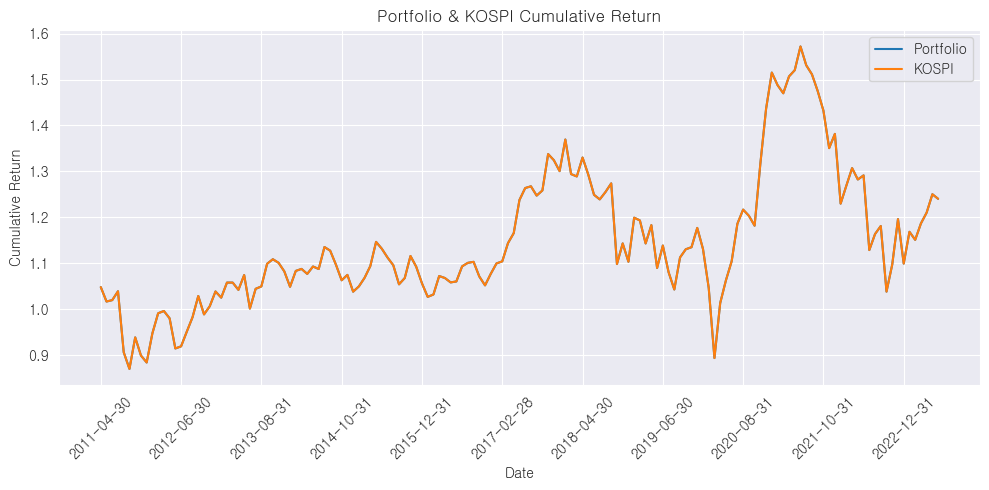

In [11]:
# # 가장 잘 나오는 그래프

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# # 함수 정의: 최대 손실 낙폭(Maximum Drawdown)
# def MDD(price_series):
#     max_value = price_series.expanding(min_periods=1).max()
#     drawdown = price_series / max_value - 1.0
#     return drawdown.min()

# # 함수 정의: 변환(up=2, neutral=1, down=0)
# def convert_num(pred):
#     mapping = {2: 'up', 1: 'neutral', 0: 'down'}
#     return pred.map(mapping)

# # 월간 시장수익률 데이터 가져오기
# kdata = pd.read_csv("kospi_month_end.csv")

# # 예측된 값(y_pred)을 직접 입력하거나 외부에서 불러오기
# # y_pred = pd.Series([0, 1, 2] * (len(kdata) // 3), index=kdata.index)  # 예시

# # AI모델로 예측한 예측정보 적용
# kdata['stage'] = y_pred

# # 전월말 투자의견 열 생성
# kdata['pre_stage'] = kdata['stage'].shift(1).fillna(2)  # 첫 달은 NaN이므로 상승으로 가정
# kdata['port_return'] = 0

# # 전략 수익률 생성
# kdata['port_return'] = np.where(kdata['pre_stage'] == 2, kdata['m_return'], 0)
# kdata['port_return'] = np.where(kdata['pre_stage'] == 0, -kdata['m_return'], kdata['port_return'])

# # 누적수익률 생성
# kdata['kospi_cumul'] = (1 + kdata['m_return']).cumprod()
# kdata['port_cumul'] = (1 + kdata['port_return']).cumprod()

# # 백테스팅 결과 기록(CAGR, 변동성, Sharpe ratio, MDD)
# my_back = {'months': len(kdata)}
# years = my_back['months'] / 12

# # 코스피 지수에 대한 계산
# my_back['k_cumul_return'] = kdata['kospi_cumul'].iloc[-1] - 1
# my_back['k_cagr'] = (kdata['kospi_cumul'].iloc[-1])**(1/years) - 1
# my_back['k_vol'] = kdata['m_return'].std() * np.sqrt(12)
# my_back['k_Sharpe'] = my_back['k_cagr'] / my_back['k_vol']
# my_back['k_MDD'] = MDD(kdata['kospi_cumul'])

# # 포트폴리오에 대한 계산
# my_back['port_cumul_return'] = kdata['port_cumul'].iloc[-1] - 1
# my_back['port_cagr'] = (kdata['port_cumul'].iloc[-1])**(1/years) - 1
# my_back['port_vol'] = kdata['port_return'].std() * np.sqrt(12)
# my_back['port_Sharpe'] = my_back['port_cagr'] / my_back['port_vol']
# my_back['port_MDD'] = MDD(kdata['port_cumul'])

# # 백테스팅 결과 출력
# print("<Backtesting result>")
# for key, value in my_back.items():
#     print(f"{key:20}: {value:8.3f}")

# # 포트폴리오 누적수익률 그래프
# plt.figure(figsize=(10, 5))
# plt.plot(kdata.index, kdata['port_cumul'], label='Portfolio')
# plt.plot(kdata.index, kdata['kospi_cumul'], label='KOSPI')

# # x축 레이블을 날짜로 설정합니다.
# plt.xticks(kdata.index[::int(len(kdata.index)/10)], kdata['base_date'][::int(len(kdata.index)/10)], rotation=45)

# plt.title('Portfolio & KOSPI Cumulative Return')
# plt.ylabel('Cumulative Return')
# plt.xlabel('Date')
# plt.legend()
# plt.tight_layout()
# plt.grid(True)
# plt.show()

<Backtesting result>
months              :  147.000
k_cumul_return      :    0.240
k_cagr              :    0.018
k_vol               :    0.160
k_Sharpe            :    0.111
k_MDD               :   -0.348
port_cumul_return   :    0.240
port_cagr           :    0.018
port_vol            :    0.160
port_Sharpe         :    0.111
port_MDD            :   -0.348


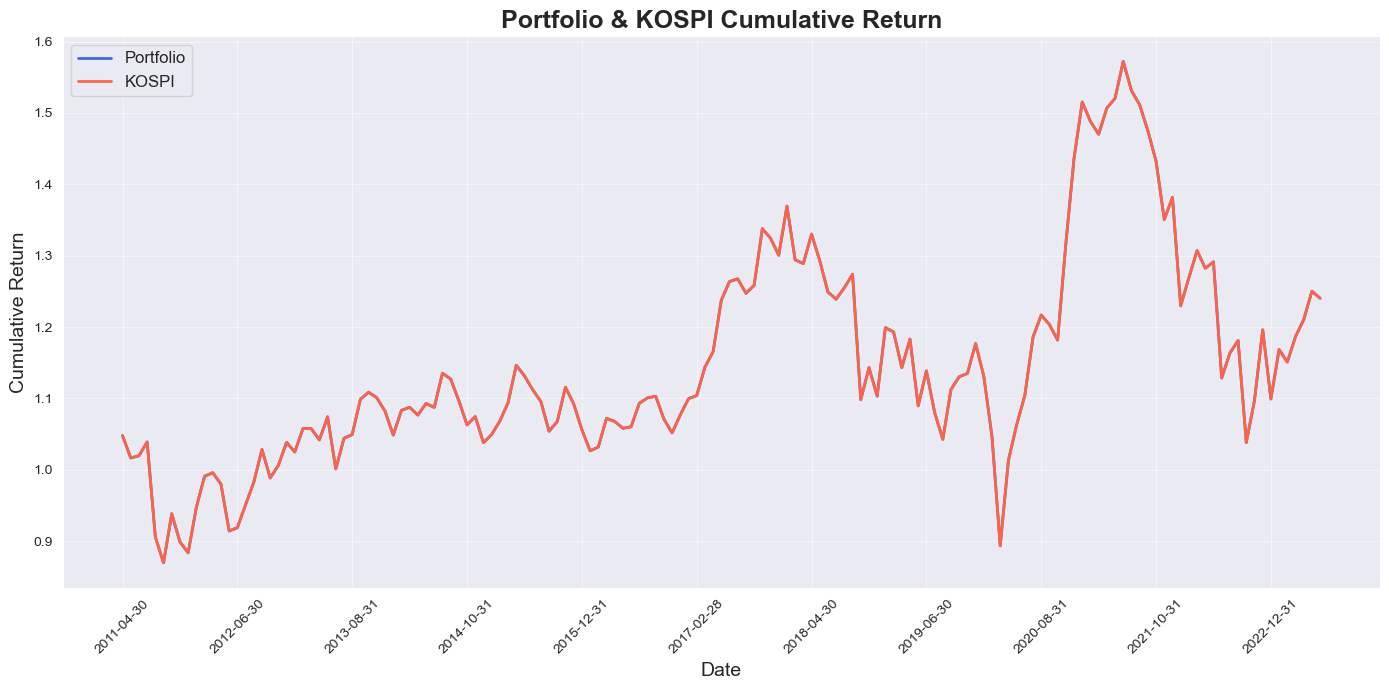

In [12]:
#시각화 예쁘게

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

# Korean font path
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 함수 정의: 최대 손실 낙폭(Maximum Drawdown)
def MDD(price_series):
    max_value = price_series.expanding(min_periods=1).max()
    drawdown = price_series / max_value - 1.0
    return drawdown.min()

# 함수 정의: 변환(up=2, neutral=1, down=0)
def convert_num(pred):
    mapping = {2: 'up', 1: 'neutral', 0: 'down'}
    return pred.map(mapping)

kdata = pd.read_csv("kospi_month_end.csv")

# Example of predicted data
# y_pred = pd.Series([0, 1, 2] * (len(kdata) // 3), index=kdata.index)


# AI모델로 예측한 예측정보 적용
kdata['stage'] = y_pred

# 전월말 투자의견 열 생성
kdata['pre_stage'] = kdata['stage'].shift(1).fillna(2)  # 첫 달은 NaN이므로 상승으로 가정
kdata['port_return'] = 0

# 전략 수익률 생성
kdata['port_return'] = np.where(kdata['pre_stage'] == 2, kdata['m_return'], 0)
kdata['port_return'] = np.where(kdata['pre_stage'] == 0, -kdata['m_return'], kdata['port_return'])

# 누적수익률 생성
kdata['kospi_cumul'] = (1 + kdata['m_return']).cumprod()
kdata['port_cumul'] = (1 + kdata['port_return']).cumprod()

# 백테스팅 결과 기록(CAGR, 변동성, Sharpe ratio, MDD)
my_back = {'months': len(kdata)}
years = my_back['months'] / 12

# 코스피 지수에 대한 계산
my_back['k_cumul_return'] = kdata['kospi_cumul'].iloc[-1] - 1
my_back['k_cagr'] = (kdata['kospi_cumul'].iloc[-1])**(1/years) - 1
my_back['k_vol'] = kdata['m_return'].std() * np.sqrt(12)
my_back['k_Sharpe'] = my_back['k_cagr'] / my_back['k_vol']
my_back['k_MDD'] = MDD(kdata['kospi_cumul'])

# 포트폴리오에 대한 계산
my_back['port_cumul_return'] = kdata['port_cumul'].iloc[-1] - 1
my_back['port_cagr'] = (kdata['port_cumul'].iloc[-1])**(1/years) - 1
my_back['port_vol'] = kdata['port_return'].std() * np.sqrt(12)
my_back['port_Sharpe'] = my_back['port_cagr'] / my_back['port_vol']
my_back['port_MDD'] = MDD(kdata['port_cumul'])

# 백테스팅 결과 출력
print("<Backtesting result>")
for key, value in my_back.items():
    print(f"{key:20}: {value:8.3f}")
# Visualization
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
plt.plot(kdata.index, kdata['port_cumul'], label='Portfolio', color='royalblue', linewidth=2)
plt.plot(kdata.index, kdata['kospi_cumul'], label='KOSPI', color='tomato', linewidth=2)

plt.xticks(kdata.index[::int(len(kdata.index)/10)], kdata['base_date'][::int(len(kdata.index)/10)], rotation=45)
plt.title('Portfolio & KOSPI Cumulative Return', fontsize=18, fontweight='bold')
plt.ylabel('Cumulative Return', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.grid(True, alpha=0.5)
plt.show()


In [13]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)


# # 1. 데이터 로딩 및 y_pred 정의
# kdata = pd.read_csv("kospi_month_end.csv")

# # y_pred 샘플에 기반하여 정의
# # 전체 y_pred 값을 알 수 없으므로 예시로 몇 가지만 정의합니다.
# y_pred_sample = {
#     "2011-04-01": 0,
#     "2011-04-04": 0,
#     "2011-04-05": 0,
#     "2011-04-06": 0,
#     "2011-04-07": 0,
#     "2023-06-26": 0,
#     "2023-06-27": 0,
#     "2023-06-28": 0,
#     "2023-06-29": 0,
#     "2023-06-30": 0,
# }

# # 2. MDD 함수 정의
# def MDD(price_series):
#     running_max = price_series.expanding(min_periods=1).max()
#     drawdown = price_series / running_max - 1.0
#     mdd = drawdown.min()
#     return mdd

# # 3. 백테스팅 전략 구현
# kdata['y_pred'] = kdata['base_date'].map(y_pred)
# kdata['y_pred_shifted'] = kdata['y_pred'].shift(1)
# kdata['port_return'] = np.where(kdata['y_pred_shifted'] == 2, kdata['m_return'],  
#                         np.where(kdata['y_pred_shifted'] == 0, -kdata['m_return'],  
#                         0))  

# # 4. 퍼포먼스 메트릭 계산 및 출력
# kdata['port_cumul'] = (1 + kdata['port_return']).cumprod()
# kdata['kospi_cumul'] = (1 + kdata['m_return']).cumprod()

# my_back = {'months': len(kdata)}
# my_back['port_MDD'] = MDD(kdata['port_cumul']) * 100
# my_back['kospi_MDD'] = MDD(kdata['kospi_cumul']) * 100

# print("<백테스팅 결과>")
# for key, value in my_back.items(): 
#     print(f"{key:22}: {value:8.3f}")

# # 5. 결과 시각화
# plt.figure(figsize=(10, 6))
# plt.plot(kdata['port_cumul'], label='Portfolio Cumulative Return')
# plt.plot(kdata['kospi_cumul'], label='KOSPI Cumulative Return')
# plt.legend()
# plt.title("백테스팅 결과")
# plt.show()


<Backtesting result>
months              :  147.000
k_cumul_return      :    0.240
k_cagr              :    0.018
k_vol               :    0.160
k_Sharpe            :    0.111
k_MDD               :   -0.348
port_cumul_return   :    0.703
port_cagr           :    0.044
port_vol            :    0.130
port_Sharpe         :    0.341
port_MDD            :   -0.233


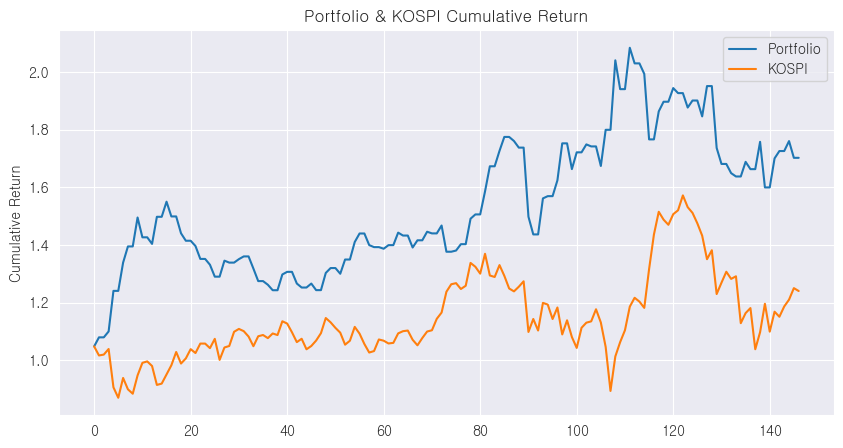

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 함수 정의: 최대 손실 낙폭(Maximum Drawdown)
def MDD(price_series):
    max_value = price_series.expanding(min_periods=1).max()
    drawdown = price_series / max_value - 1.0
    return drawdown.min()

# 함수 정의: 변환(up=2, neutral=1, down=0)
def convert_num(pred):
    mapping = {2: 'up', 1: 'neutral', 0: 'down'}
    return pred.map(mapping)

# 월간 시장수익률 데이터 가져오기
kdata = pd.read_csv("kospi_month_end.csv")

# 예측된 값(y_pred)을 직접 입력하거나 외부에서 불러오기
y_pred = pd.Series([0, 1, 2] * (len(kdata) // 3), index=kdata.index)  # 예시

# AI모델로 예측한 예측정보 적용
kdata['stage'] = y_pred

# 전월말 투자의견 열 생성
kdata['pre_stage'] = kdata['stage'].shift(1).fillna(2)  # 첫 달은 NaN이므로 상승으로 가정
kdata['port_return'] = 0

# 전략 수익률 생성
kdata['port_return'] = np.where(kdata['pre_stage'] == 2, kdata['m_return'], 0)
kdata['port_return'] = np.where(kdata['pre_stage'] == 0, -kdata['m_return'], kdata['port_return'])

# 누적수익률 생성
kdata['kospi_cumul'] = (1 + kdata['m_return']).cumprod()
kdata['port_cumul'] = (1 + kdata['port_return']).cumprod()

# 백테스팅 결과 기록(CAGR, 변동성, Sharpe ratio, MDD)
my_back = {'months': len(kdata)}
years = my_back['months'] / 12

# 코스피 지수에 대한 계산
my_back['k_cumul_return'] = kdata['kospi_cumul'].iloc[-1] - 1
my_back['k_cagr'] = (kdata['kospi_cumul'].iloc[-1])**(1/years) - 1
my_back['k_vol'] = kdata['m_return'].std() * np.sqrt(12)
my_back['k_Sharpe'] = my_back['k_cagr'] / my_back['k_vol']
my_back['k_MDD'] = MDD(kdata['kospi_cumul'])

# 포트폴리오에 대한 계산
my_back['port_cumul_return'] = kdata['port_cumul'].iloc[-1] - 1
my_back['port_cagr'] = (kdata['port_cumul'].iloc[-1])**(1/years) - 1
my_back['port_vol'] = kdata['port_return'].std() * np.sqrt(12)
my_back['port_Sharpe'] = my_back['port_cagr'] / my_back['port_vol']
my_back['port_MDD'] = MDD(kdata['port_cumul'])

# 백테스팅 결과 출력
print("<Backtesting result>")
for key, value in my_back.items():
    print(f"{key:20}: {value:8.3f}")

# 포트폴리오 누적수익률 그래프
plt.figure(figsize=(10, 5))
kdata['port_cumul'].plot(label='Portfolio')
kdata['kospi_cumul'].plot(label='KOSPI')
plt.title('Portfolio & KOSPI Cumulative Return')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# 모델 전망치와 실제결과치 출력


<Backtesting result>
months              :  147.000
k_cumul_return      :    0.240
k_cagr              :    0.018
k_vol               :    0.160
k_Sharpe            :    0.111
k_MDD               :   -0.348
port_cumul_return   :    0.703
port_cagr           :    0.044
port_vol            :    0.130
port_Sharpe         :    0.341
port_MDD            :   -0.233


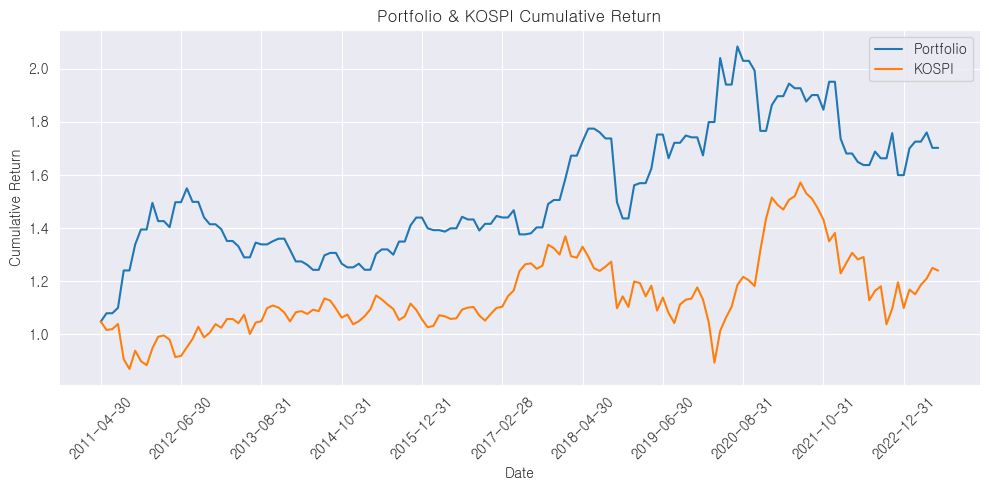

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 함수 정의: 최대 손실 낙폭(Maximum Drawdown)
def MDD(price_series):
    max_value = price_series.expanding(min_periods=1).max()
    drawdown = price_series / max_value - 1.0
    return drawdown.min()

# 함수 정의: 변환(up=2, neutral=1, down=0)
def convert_num(pred):
    mapping = {2: 'up', 1: 'neutral', 0: 'down'}
    return pred.map(mapping)

# 월간 시장수익률 데이터 가져오기
kdata = pd.read_csv("kospi_month_end.csv")

# 예측된 값(y_pred)을 직접 입력하거나 외부에서 불러오기
y_pred = pd.Series([0, 1, 2] * (len(kdata) // 3), index=kdata.index)  # 예시

# AI모델로 예측한 예측정보 적용
kdata['stage'] = y_pred

# 전월말 투자의견 열 생성
kdata['pre_stage'] = kdata['stage'].shift(1).fillna(2)  # 첫 달은 NaN이므로 상승으로 가정
kdata['port_return'] = 0

# 전략 수익률 생성
kdata['port_return'] = np.where(kdata['pre_stage'] == 2, kdata['m_return'], 0)
kdata['port_return'] = np.where(kdata['pre_stage'] == 0, -kdata['m_return'], kdata['port_return'])

# 누적수익률 생성
kdata['kospi_cumul'] = (1 + kdata['m_return']).cumprod()
kdata['port_cumul'] = (1 + kdata['port_return']).cumprod()

# 백테스팅 결과 기록(CAGR, 변동성, Sharpe ratio, MDD)
my_back = {'months': len(kdata)}
years = my_back['months'] / 12

# 코스피 지수에 대한 계산
my_back['k_cumul_return'] = kdata['kospi_cumul'].iloc[-1] - 1
my_back['k_cagr'] = (kdata['kospi_cumul'].iloc[-1])**(1/years) - 1
my_back['k_vol'] = kdata['m_return'].std() * np.sqrt(12)
my_back['k_Sharpe'] = my_back['k_cagr'] / my_back['k_vol']
my_back['k_MDD'] = MDD(kdata['kospi_cumul'])

# 포트폴리오에 대한 계산
my_back['port_cumul_return'] = kdata['port_cumul'].iloc[-1] - 1
my_back['port_cagr'] = (kdata['port_cumul'].iloc[-1])**(1/years) - 1
my_back['port_vol'] = kdata['port_return'].std() * np.sqrt(12)
my_back['port_Sharpe'] = my_back['port_cagr'] / my_back['port_vol']
my_back['port_MDD'] = MDD(kdata['port_cumul'])

# 백테스팅 결과 출력
print("<Backtesting result>")
for key, value in my_back.items():
    print(f"{key:20}: {value:8.3f}")

# 포트폴리오 누적수익률 그래프
plt.figure(figsize=(10, 5))
plt.plot(kdata.index, kdata['port_cumul'], label='Portfolio')
plt.plot(kdata.index, kdata['kospi_cumul'], label='KOSPI')

# x축 레이블을 날짜로 설정합니다.
plt.xticks(kdata.index[::int(len(kdata.index)/10)], kdata['base_date'][::int(len(kdata.index)/10)], rotation=45)

plt.title('Portfolio & KOSPI Cumulative Return')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()